In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
import pandas as pd

/Users/andrestrepo/Documents/repos_personal/poc-summary/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
login(token = os.environ.get("HF_TOKEN") )

dataset_name = "AndresR2909/youtube_transcriptions_summaries_2025_gpt4.1"

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
sel_columns = ["channel_name","video_id","publish_date","year","month","number_of_tokenks","duration"]
df_test = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["test"], columns=sel_columns)
df_train = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["train"], columns= sel_columns)

In [6]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all

,channel_name,video_id,publish_date,year,month,number_of_tokenks,duration
0,Bolsas hoy | Invierte y Crece,MEFcIWdwoEI,None,0,NaN,2389,822.0
1,Bolsas hoy | Invierte y Crece,yQdTS2296V8,None,0,NaN,3639,1251.0
2,Bolsas hoy | Invierte y Crece,5uDK19-gLkw,None,0,NaN,2847,907.0
3,Bolsas hoy | Invierte y Crece,dm-GKckZQG4,None,0,NaN,3380,1142.0
4,Bolsas hoy | Invierte y Crece,n4ZxNi2TjaY,None,0,NaN,3221,1055.0
...,...,...,...,...,...,...,...
2220,USACRYPTONOTICIAS,kE4PHBzjK9w,None,0,NaN,1263,451.0
2221,USACRYPTONOTICIAS,84zFrrHaBCw,2022-08-01,2022,8.0,1781,595.0
2222,USACRYPTONOTICIAS,F4-oXv3oB9w,None,0,NaN,18974,6879.0
2223,USACRYPTONOTICIAS,oi9z9YkeUZ8,None,0,NaN,4231,1579.0


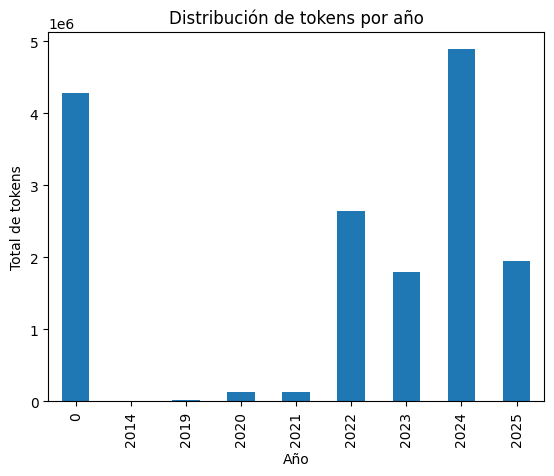

In [15]:
import matplotlib.pyplot as plt

df_all.groupby('year')['number_of_tokenks'].sum().plot(kind='bar')
plt.xlabel('Año')
plt.ylabel('Total de tokens')
plt.title('Distribución de tokens por año')
plt.show()

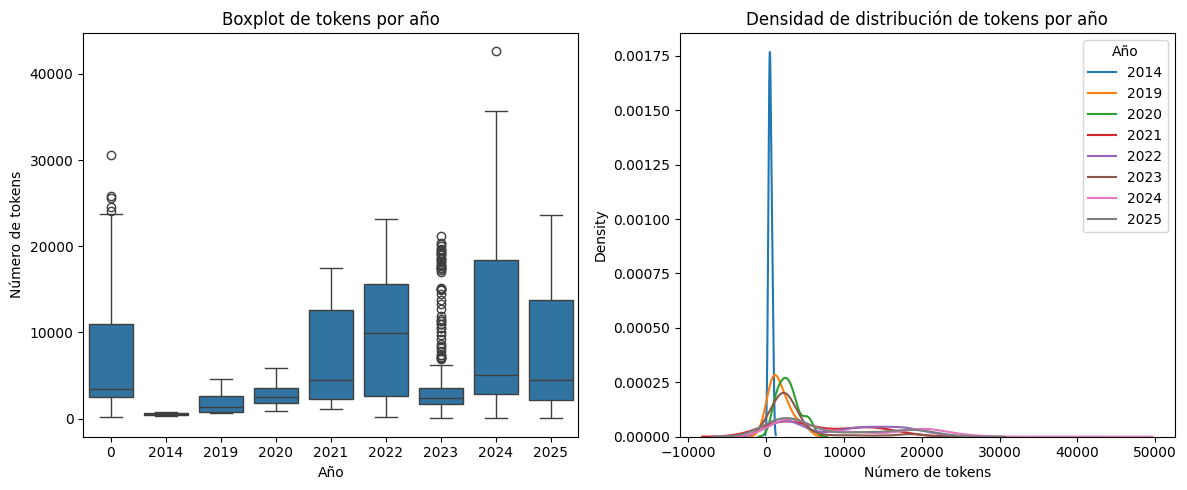

In [20]:
import seaborn as sns

plt.figure(figsize=(12, 5))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='year', y='number_of_tokenks', data=df_all)#[df_all['year'] != 0])
plt.title('Boxplot de tokens por año')
plt.xlabel('Año')
plt.ylabel('Número de tokens')

# Densidad
plt.subplot(1, 2, 2)
for year, group in df_all[df_all['year'] != 0].groupby('year'):
    sns.kdeplot(group['number_of_tokenks'], label=str(year))
plt.title('Densidad de distribución de tokens por año')
plt.xlabel('Número de tokens')
plt.legend(title='Año')

plt.tight_layout()
plt.show()

In [29]:
# Crear un dataframe base con todos los canales
canales = df_all['channel_name'].unique()
df_final = pd.DataFrame({'channel_name': canales})
quantiles = [0.5, 0.75, 0.95]
for q in quantiles:
    percentil = df_all['number_of_tokenks'].quantile(q)
    df_bajo_percentil = df_all[df_all['number_of_tokenks'] < percentil]
    videos_por_canal = df_bajo_percentil['channel_name'].value_counts()
    total_videos_por_canal = df_all['channel_name'].value_counts()
    porcentaje = (videos_por_canal / total_videos_por_canal) * 100

    q_str = str(int(q*100))
    df_final[f'videos_cuantil_{q_str}'] = df_final['channel_name'].map(videos_por_canal).fillna(0).astype(int)
    df_final[f'porcentaje_cuantil_{q_str}'] = df_final['channel_name'].map(porcentaje).fillna(0)

df_final['total_videos'] = df_final['channel_name'].map(total_videos_por_canal).fillna(0).astype(int)
df_final


,channel_name,videos_cuantil_50,porcentaje_cuantil_50,videos_cuantil_75,porcentaje_cuantil_75,videos_cuantil_95,porcentaje_cuantil_95,total_videos
0,Bolsas hoy | Invierte y Crece,183,63.103448,287,98.965517,290,100.000000,290
1,USACRYPTONOTICIAS,158,17.286652,363,39.715536,802,87.746171,914
2,Esteban Perez,644,79.408138,809,99.753391,811,100.000000,811
3,ARENA ALFA,87,60.000000,144,99.310345,145,100.000000,145
4,Bitcoin hoy,28,53.846154,52,100.000000,52,100.000000,52
5,Bolsas hoy | Esteban Pérez,12,92.307692,13,100.000000,13,100.000000,13
